# Simulate stochastic process

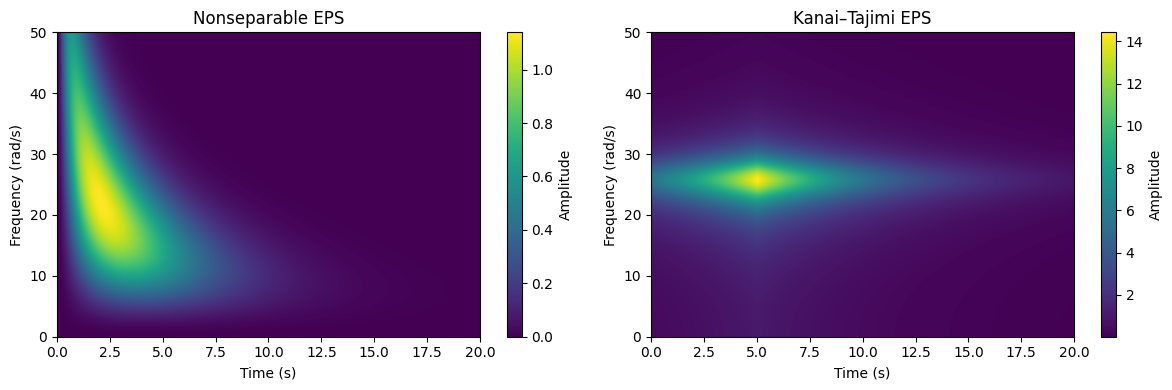

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from eps.nonsep import nonseparable_evolutionary_power_spectrum
from eps.kt import kt_evolutionary_power_spectrum

time = np.linspace(0, 20, 512)
freq = np.linspace(0, 50, 512)

X, Y = np.meshgrid(time, freq)

eps_cp = np.zeros((len(time), len(freq)))
eps_kt = np.zeros((len(time), len(freq)))

#EPSs parameters
S0 = 1
b0 = 0.47500000000000003

#KT parameter
omega_g = 26.25
zeta_g = 0.1375

for i in range(len(time)):
    for j in range(len(freq)):
        eps_cp[i][j] = nonseparable_evolutionary_power_spectrum(freq[j], time[i], S0, b0)
        eps_kt[i][j] = kt_evolutionary_power_spectrum(freq[j], time[i], S0, omega_g, zeta_g, b0, 5)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

im0 = axes[0].imshow(
    eps_cp.T,                  # transpose so freq is y-axis
    extent=[time.min(), time.max(), freq.min(), freq.max()],
    origin='lower',
    aspect='auto',
    cmap=cm.viridis
)
axes[0].set_title("Nonseparable EPS")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Frequency (rad/s)")
fig.colorbar(im0, ax=axes[0], label="Amplitude")

im1 = axes[1].imshow(
    eps_kt.T,                  # transpose so freq is y-axis
    extent=[time.min(), time.max(), freq.min(), freq.max()],
    origin='lower',
    aspect='auto',
    cmap=cm.viridis
)
axes[1].set_title("Kanai–Tajimi EPS")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Frequency (rad/s)")
fig.colorbar(im1, ax=axes[1], label="Amplitude")

plt.tight_layout()
plt.show()

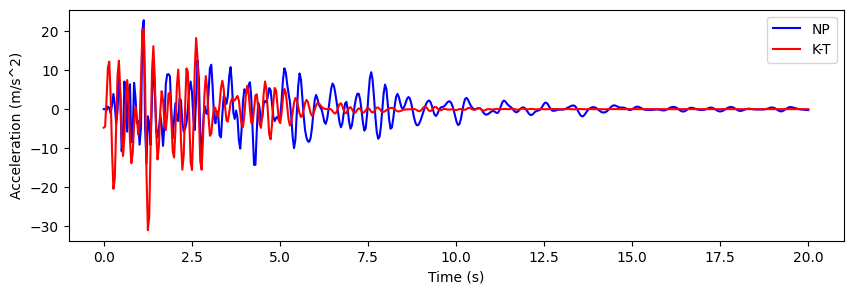

In [80]:
from simulate_process import simulate_process
import pandas as pd

w_cp = np.zeros((200, len(time)))
w_kt = np.zeros((200, len(time)))

for i in range(w_cp.shape[0]):
    w_cp[i,:] = simulate_process(time, S0, max(freq), omega_g, zeta_g, b0)
    w_kt[i,:] = simulate_process(time, S0, omega_g, omega_g, zeta_g, b0, eps_type='kt')

fig = plt.figure(figsize=(10,3))

plt.plot(time, w_cp[10,:], 'b')
plt.plot(time, w_kt[10,:], 'r')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend(['NP', 'K-T'])
plt.show()

w_cp_df = pd.DataFrame(w_cp.T).add_prefix('cp_')
w_kt_df = pd.DataFrame(w_kt.T).add_prefix('kt_')

df_results = pd.concat([w_cp_df, w_kt_df], axis=1)
df_results['time'] = time
df_results.to_csv(f'data/realizations/stochastic_process_{S0}_{b0}_{omega_g}_{zeta_g}.csv', index=False)

# GHW

In [81]:
import numpy as np
import pandas as pd
from wavelet.get_band_options import ghw_band_options

df = pd.read_csv(f'data/realizations/stochastic_process_{S0}_{b0}_{omega_g}_{zeta_g}.csv')

t = df["time"].values
x = df["cp_1"].values

dt = np.diff(t)
fs = 1.0 / np.median(dt)
print(f"Estimated fs = {fs:.2f} Hz")
print(f"Max dt = {max(dt):.4f} s")

# bands
bins_per_band = 4
uniform_bands, adaptive_bands, freqs = ghw_band_options(x, fs, bins_per_band=bins_per_band, spike_prominence=1e-1)

Estimated fs = 25.55 Hz
Max dt = 0.0391 s


In [82]:
from wavelet.ghw_transform import ghw_transform

# Apply GHW
out_uniform = ghw_transform(x, fs, uniform_bands, analytic=True, return_downsampled=False)
out_adaptive = ghw_transform(x, fs, adaptive_bands, analytic=True, return_downsampled=False)

# Extract coefficients and bands from ghw_transform output
coeffs = out_uniform["complex"]    # list of arrays per band
bands = out_uniform["bands"]       # (flo, fhi) Hz

num_bands = len(coeffs)

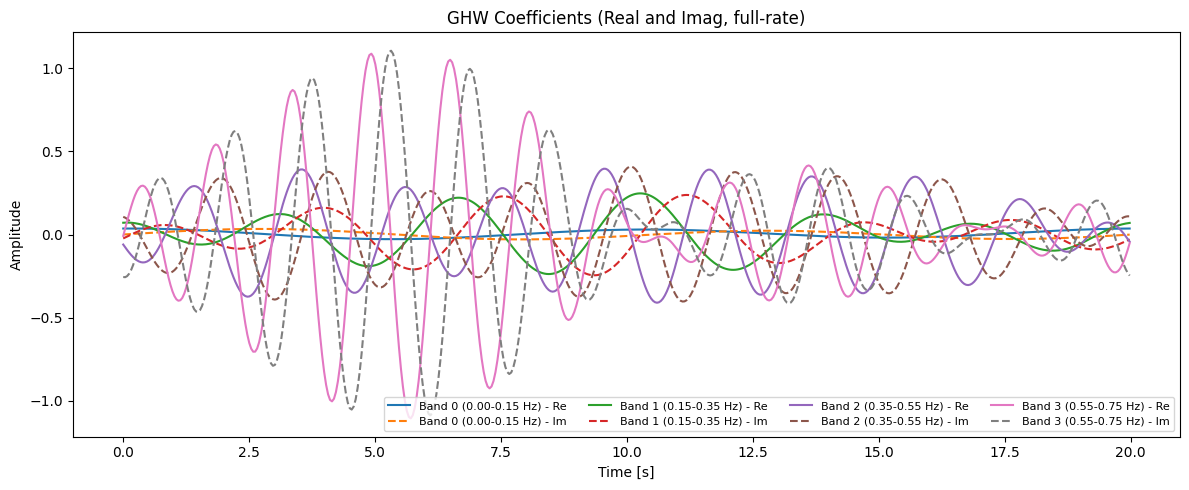

In [83]:
import numpy as np
import matplotlib.pyplot as plt

time = np.linspace(0, 40, 1024)
dt = time[1] - time[0]
t_original = np.arange(len(x)) * dt

plt.figure(figsize=(12,5))
n_bands_to_plot = 4 

for i in range(min(n_bands_to_plot, len(coeffs))):
    c = coeffs[i]
    plt.plot(t_original, c.real, label=f"Band {i} ({bands[i,0]:.2f}-{bands[i,1]:.2f} Hz) - Re")
    plt.plot(t_original, c.imag, "--", label=f"Band {i} ({bands[i,0]:.2f}-{bands[i,1]:.2f} Hz) - Im")

plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("GHW Coefficients (Real and Imag, full-rate)")
plt.legend(fontsize=8, ncol=n_bands_to_plot)
plt.tight_layout()
plt.show()

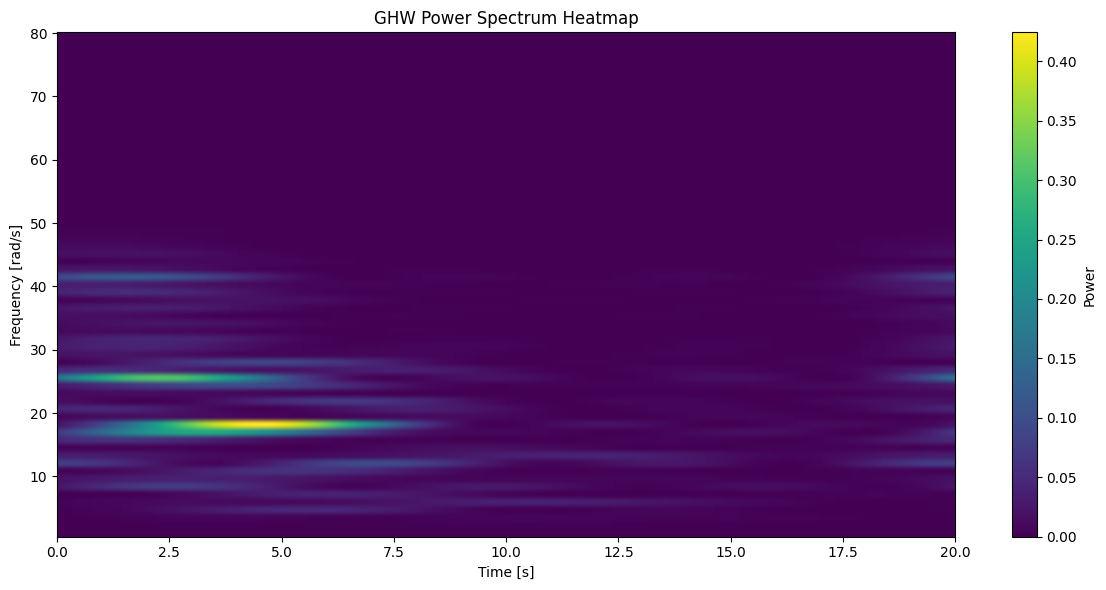

In [84]:
import numpy as np
import matplotlib.pyplot as plt

time = np.linspace(0,20,512)
power_matrix = np.array([np.abs(c)**2/(2*np.pi*4) for c in coeffs])
freq_centers = 2*np.pi*np.array([(b[0]+b[1])/2 for b in bands])

plt.figure(figsize=(12,6))
plt.imshow(power_matrix, aspect='auto', origin='lower',
           extent=[time[0], time[-1], freq_centers[0], freq_centers[-1]])
plt.colorbar(label='Power')
plt.xlabel("Time [s]")
plt.ylabel("Frequency [rad/s]")
plt.title("GHW Power Spectrum Heatmap")
plt.tight_layout()
plt.show()

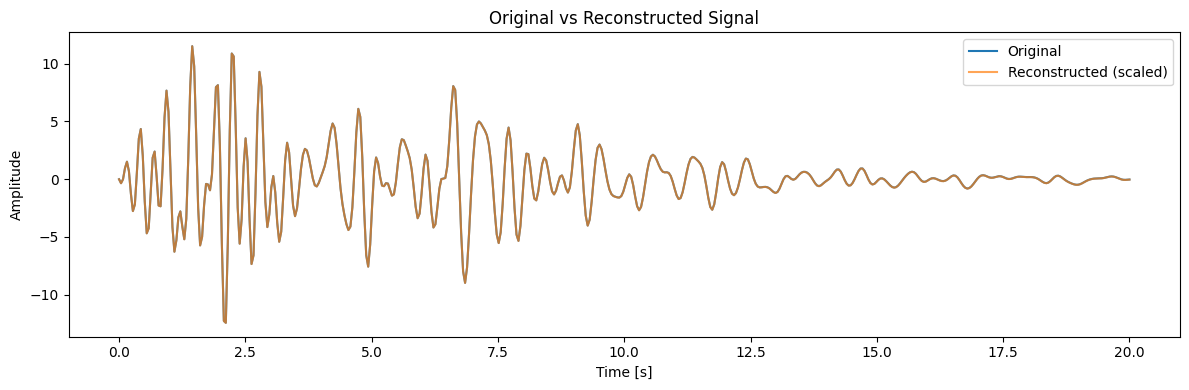

In [67]:
x_rec = out_uniform["reconstruct_fullrate"]()

# Scale to match original signal RMS
scale = np.std(x) / np.std(x_rec)
x_rec_scaled = x_rec * scale

plt.figure(figsize=(12,4))
plt.plot(time, x, label="Original")
plt.plot(time, x_rec_scaled, label="Reconstructed (scaled)", alpha=0.7)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Original vs Reconstructed Signal")
plt.legend()
plt.tight_layout()
plt.show()


# Get coef

data/transformations/stochastic_process_1.0_0.4_38.75_0.1375_freq_cp_50.0_freq_kt_38.75_cp_140.pkl


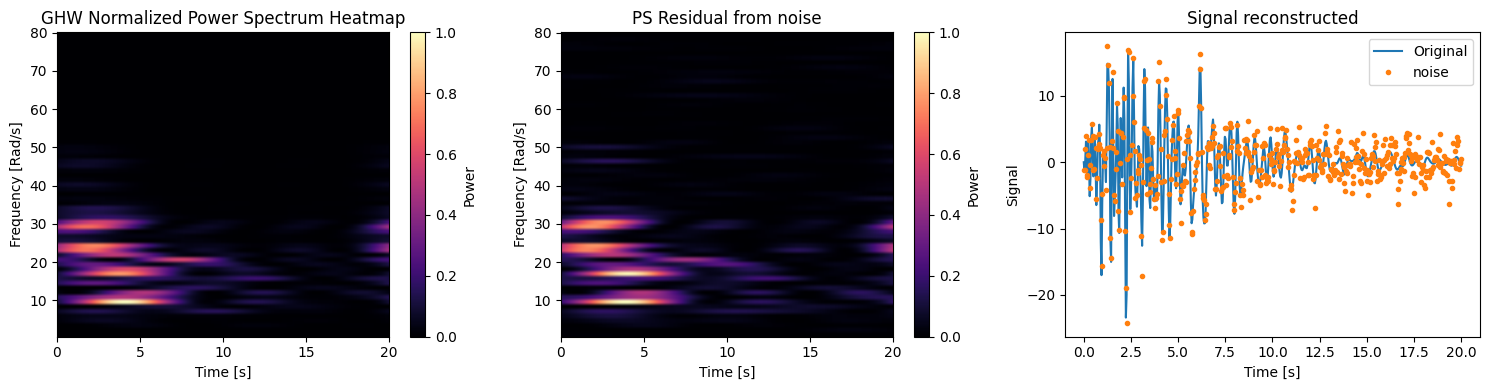

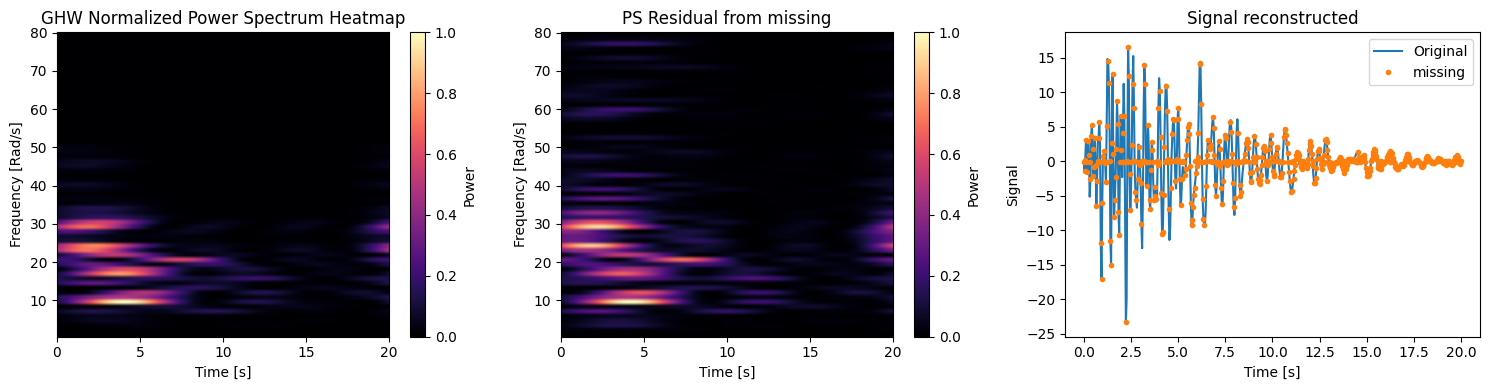

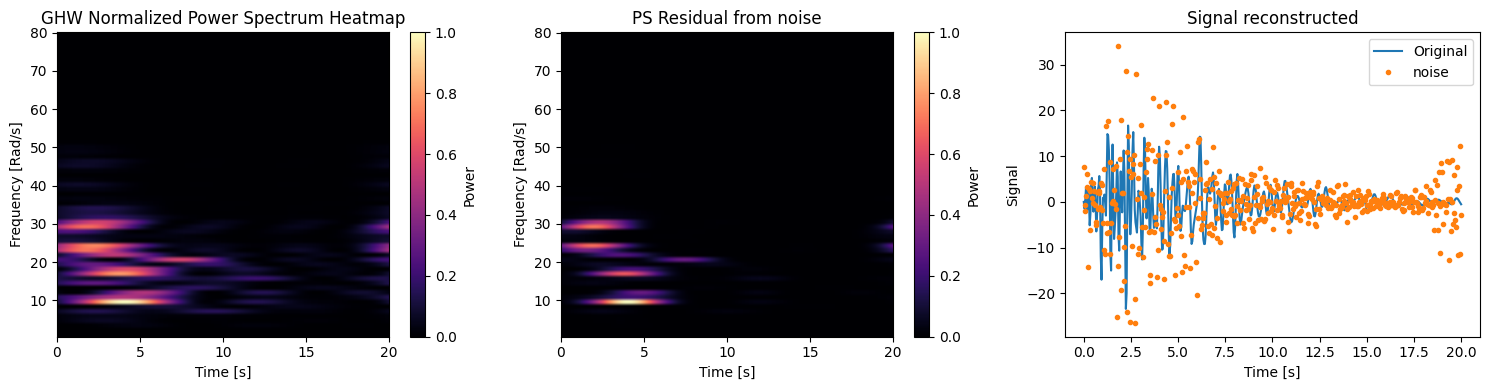

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_power(df: pd.DataFrame, df_aux = None, tmax: float = 20, timesteps: int = 512, width = 4, df_type = None): 
    time = np.linspace(0, tmax, timesteps)
    freq_centers = 2*np.pi*df['freq_centers'].values
    coeffs = df.drop(columns='freq_centers')
    power_matrix = np.array([np.abs(c)**2/(2*np.pi*width) for c in coeffs.values])
    normalized_power_matrix = (power_matrix - power_matrix.min()) / (power_matrix.max() - power_matrix.min())

    if df_aux is not None:
        coeffs_aux = df_aux.drop(columns='freq_centers')
        power_matrix_aux = np.array([np.abs(coeffs_aux)**2/(2*np.pi*width) for coeffs_aux in coeffs_aux.values])
        normalized_power_matrix_aux = (power_matrix_aux - power_matrix_aux.min()) / (power_matrix_aux.max() - power_matrix_aux.min())

    if df_aux is None:
        fig = plt.figure(figsize=(8,4))
        plt.subplot(1,2,1)
        plt.imshow(normalized_power_matrix, aspect='auto', origin='lower', extent=[time[0], time[-1], freq_centers[0], freq_centers[-1]], cmap='magma')
        plt.colorbar(label='Power')
        plt.xlabel("Time [s]")
        plt.ylabel("Frequency [Rad/s]")
        plt.title("GHW Normalized Power Spectrum Heatmap")

        plt.subplot(1,2,2)
        reconstructed_signal = np.sum(coeffs.values.real, axis=0)
        plt.plot(time, reconstructed_signal)
        plt.xlabel("Time [s]")
        plt.ylabel("Signal")
        plt.title("Signal reconstructed")

    else:
        fig = plt.figure(figsize=(15,4))
        plt.subplot(1,3,1)
        plt.imshow(normalized_power_matrix, aspect='auto', origin='lower', extent=[time[0], time[-1], freq_centers[0], freq_centers[-1]], cmap='magma')
        plt.colorbar(label='Power')
        plt.xlabel("Time [s]")
        plt.ylabel("Frequency [Rad/s]")
        plt.title("GHW Normalized Power Spectrum Heatmap")

        plt.subplot(1,3,2)
        plt.imshow(np.abs(normalized_power_matrix_aux), aspect='auto', origin='lower', extent=[time[0], time[-1], freq_centers[0], freq_centers[-1]], cmap='magma')
        plt.colorbar(label='Power')
        plt.xlabel("Time [s]")
        plt.ylabel("Frequency [Rad/s]")
        plt.title(f"PS Residual from {df_type}")

        plt.subplot(1,3,3)
        reconstructed_signal = np.sum(coeffs.values.real, axis=0)
        reconstructed_signal_aux = np.sum(coeffs_aux.values.real, axis=0)
        plt.plot(time, reconstructed_signal)
        plt.plot(time, reconstructed_signal_aux, '.')
        plt.legend(['Original', f'{df_type}'])
        plt.xlabel("Time [s]")
        plt.ylabel("Signal")
        plt.title("Signal reconstructed")

    plt.tight_layout()
    plt.show()

import os

directory_path = 'data/transformations/'

all_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) 
                if os.path.isfile(os.path.join(directory_path, f))]

all_files = [f for f in all_files if 'noisy' not in f and 'missing' not in f]

filename = all_files[10]
print(filename)
df : pd.DataFrame = pd.read_pickle(filename)
df_noisy : pd.DataFrame = pd.read_pickle(f'{filename.split('.pkl')[0]}_noisy.pkl')
df_missing: pd.DataFrame = pd.read_pickle(f'{filename.split('.pkl')[0]}_missing.pkl')

df_nm = pd.DataFrame(df_noisy.drop(columns='freq_centers').values * df_missing.drop(columns='freq_centers').values)
df_nm['freq_centers'] = df_noisy['freq_centers']

plot_power(df, df_noisy, df_type='noise')
plot_power(df, df_missing, df_type='missing')
plot_power(df, df_nm, df_type='noise')

In [3]:
df.shape

(65, 513)

# CAE

In [ ]:
import os, re, numpy as np, pandas as pd, torch
from torch.utils.data import Dataset, random_split, DataLoader

def load_complex_64x512(path):
    df: pd.DataFrame = pd.read_pickle(path)
    arr = np.array(df.values, dtype=np.complex64)
    arr = arr[:-1, :-1]  # 65x513 -> 64x512
    return arr

def complex_to_2ch(arr_c64):
    x = np.stack([arr_c64.real, arr_c64.imag], axis=0).astype(np.float32)  # (2,64,512)
    return x

class ComplexPairDataset(Dataset):
    def __init__(self, root):
        self.root = root
        all_files = [os.path.join(root, f) for f in os.listdir(root) if f.endswith(".pkl")]
        self.corrupted = [f for f in all_files if ("noisy" in f.lower() or "missing" in f.lower())]
        self.pairs = []
        for cpath in self.corrupted:
            clean_name = re.sub(r'_(noisy|missing)$', '', os.path.basename(cpath))
            clean_path = os.path.join(root, clean_name)
            if not os.path.exists(clean_path):
                raise FileNotFoundError(f"No clean file for: {cpath}")
            self.pairs.append((clean_path, cpath))

    def __len__(self): return len(self.pairs)

    def __getitem__(self, idx):
        clean_path, corr_path = self.pairs[idx]
        Xc = complex_to_2ch(load_complex_64x512(clean_path))
        Yc = complex_to_2ch(load_complex_64x512(corr_path))

        # Scale by clean’s peak (shared scale) → target-consistent, tanh-friendly
        s = np.max(np.abs(Xc)) + 1e-8
        Xc = np.clip(Xc / s, -1.0, 1.0)
        Yc = np.clip(Yc / s, -1.0, 1.0)

        # Conditioning vector c = [s0, b0, omega_g, zeta_g]
        fname = os.path.basename(clean_path)
        floats = re.findall(r"[-+]?\d*\.\d+|\d+", fname)
        s0, b0, omega_g, zeta_g = map(float, floats[:4])
        c = np.array([s0, b0, omega_g, zeta_g], dtype=np.float32)

        return torch.from_numpy(Xc), torch.from_numpy(Yc), torch.from_numpy(c)

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class ComplexCAE_LatentMap(nn.Module):
    """
    In  : [B, 2, 64, 512]   (Re/Im, F, T)
    Lat : [B, 2, 32,  64]   (Re/Im, F/2, T/8)
    Out : [B, 2, 64, 512]
    """
    def __init__(self, base=32):
        super().__init__()
        # ---------- Encoder ----------
        self.enc = nn.Sequential(
            nn.Conv2d(2,    base,   3, stride=(2,2), padding=1), nn.GELU(),  # 64x512 -> 32x256
            nn.Conv2d(base, base,   3, stride=(1,2), padding=1), nn.GELU(),  # 32x256 -> 32x128
            nn.Conv2d(base, 2*base, 3, stride=(1,2), padding=1), nn.GELU(),  # 32x128 -> 32x64
            nn.Conv2d(2*base, 2,    1, stride=1,     padding=0)              # -> 2 channels (Re/Im latent)
        )
        # ---------- Decoder ----------
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(2,    2*base, 3, stride=(1,2), padding=1, output_padding=(0,1)), nn.GELU(), # 32x64 -> 32x128
            nn.ConvTranspose2d(2*base,base,  3, stride=(1,2), padding=1, output_padding=(0,1)), nn.GELU(), # 32x128 -> 32x256
            nn.ConvTranspose2d(base, base,   3, stride=(2,2), padding=1, output_padding=(0,0)), nn.GELU(), # 32x256 -> 64x512
            nn.Conv2d(base, 2, 3, padding=1),
            nn.Tanh()  # outputs normalized Re/Im in [-1, 1]
        )

    def encode(self, x):      # x: [B,2,64,512]
        z = self.enc(x)       # z: [B,2,32,64]
        return z

    def decode(self, z):      # z: [B,2,32,64]
        xhat = self.dec(z)    # [B,2,64,512]
        return xhat

    def forward(self, x):
        z = self.encode(x)
        xhat = self.decode(z)
        # safeguard, should already match:
        if xhat.shape[-2:] != x.shape[-2:]:
            xhat = F.interpolate(xhat, size=x.shape[-2:], mode='bilinear', align_corners=False)
        return xhat, z


In [3]:
from torch.utils.data import DataLoader, random_split
import torch, torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cudnn.benchmark = True
if hasattr(torch, "set_float32_matmul_precision"):
    torch.set_float32_matmul_precision("high")

ds = ComplexPairDataset("data/transformations")
N = len(ds); n_train = int(0.8*N); n_val = N - n_train
train_ds, val_ds = random_split(ds, [n_train, n_val], generator=torch.Generator().manual_seed(0))

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True,
                          num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)
val_loader   = DataLoader(val_ds,   batch_size=128, shuffle=False,
                          num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

cae = ComplexCAE_LatentMap().to(device).to(memory_format=torch.channels_last)
opt = torch.optim.AdamW(cae.parameters(), lr=2e-4, weight_decay=1e-4)
crit = nn.MSELoss()

# AMP (new API)
scaler = torch.amp.GradScaler(device="cuda") if device=="cuda" else None
def autocast_ctx():
    return torch.amp.autocast(device_type="cuda", enabled=(device=="cuda"))

best_val = float("inf")
epochs = 80
print('starting training')

for ep in range(1, epochs+1):
    cae.train(); tr_loss = 0.0
    for Xc, Yc, c in train_loader:
        Xc = Xc.to(device, non_blocking=True).to(memory_format=torch.channels_last)
        Yc = Yc.to(device, non_blocking=True).to(memory_format=torch.channels_last)

        opt.zero_grad(set_to_none=True)
        with autocast_ctx():
            Xhat, z = cae(Yc)      # denoising: input is corrupted
            loss   = crit(Xhat, Xc)  # target is clean

        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
        else:
            loss.backward()
            opt.step()

        tr_loss += loss.item() * Xc.size(0)
    tr_loss /= len(train_loader.dataset)

    cae.eval(); va_loss = 0.0
    with torch.no_grad():
        for Xc, Yc, c in val_loader:
            Xc = Xc.to(device, non_blocking=True).to(memory_format=torch.channels_last)
            Yc = Yc.to(device, non_blocking=True).to(memory_format=torch.channels_last)
            with autocast_ctx():
                Xhat, z = cae(Yc)
                loss = crit(Xhat, Xc)
            va_loss += loss.item() * Xc.size(0)
    va_loss /= len(val_loader.dataset)

    print(f"[CAE Denoise] Epoch {ep:03d}  train {tr_loss:.6f}  val {va_loss:.6f}")

    if va_loss < best_val:
        best_val = va_loss
        torch.save(cae, "cae_denoise_best.pt")


starting training
[CAE Denoise] Epoch 001  train 0.017508  val 0.014054
[CAE Denoise] Epoch 002  train 0.012207  val 0.010067
[CAE Denoise] Epoch 003  train 0.008622  val 0.007652
[CAE Denoise] Epoch 004  train 0.007245  val 0.006946
[CAE Denoise] Epoch 005  train 0.006750  val 0.006582
[CAE Denoise] Epoch 006  train 0.006453  val 0.006333
[CAE Denoise] Epoch 007  train 0.006240  val 0.006149
[CAE Denoise] Epoch 008  train 0.006074  val 0.005998
[CAE Denoise] Epoch 009  train 0.005942  val 0.005883
[CAE Denoise] Epoch 010  train 0.005835  val 0.005786
[CAE Denoise] Epoch 011  train 0.005748  val 0.005706
[CAE Denoise] Epoch 012  train 0.005675  val 0.005644
[CAE Denoise] Epoch 013  train 0.005610  val 0.005577
[CAE Denoise] Epoch 014  train 0.005555  val 0.005523
[CAE Denoise] Epoch 015  train 0.005505  val 0.005489
[CAE Denoise] Epoch 016  train 0.005461  val 0.005435
[CAE Denoise] Epoch 017  train 0.005421  val 0.005400
[CAE Denoise] Epoch 018  train 0.005385  val 0.005361
[CAE Denoi

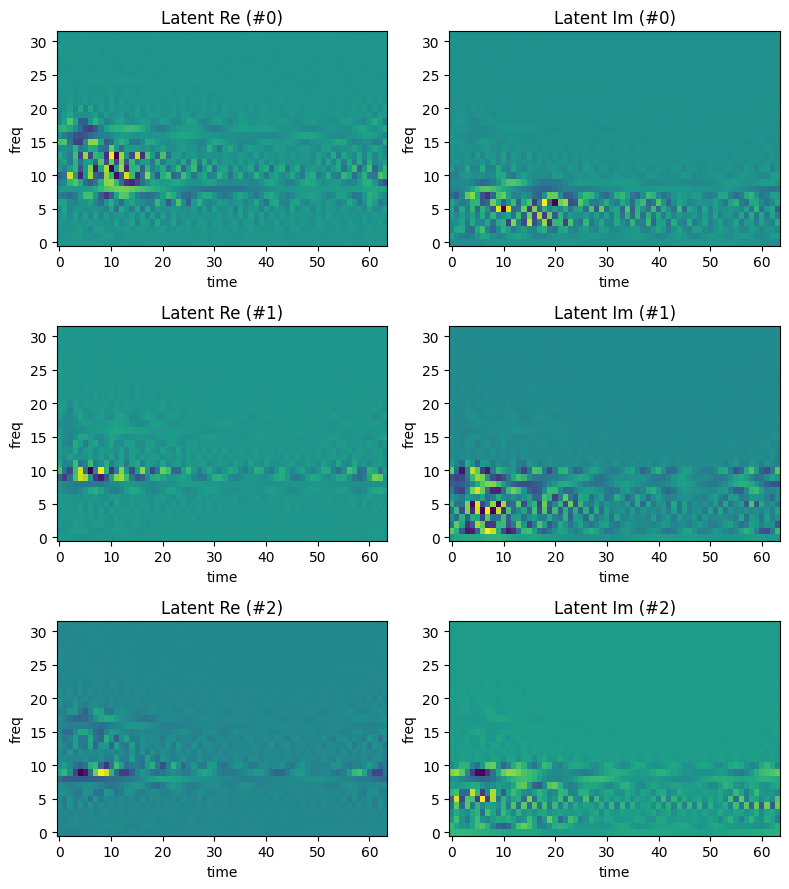

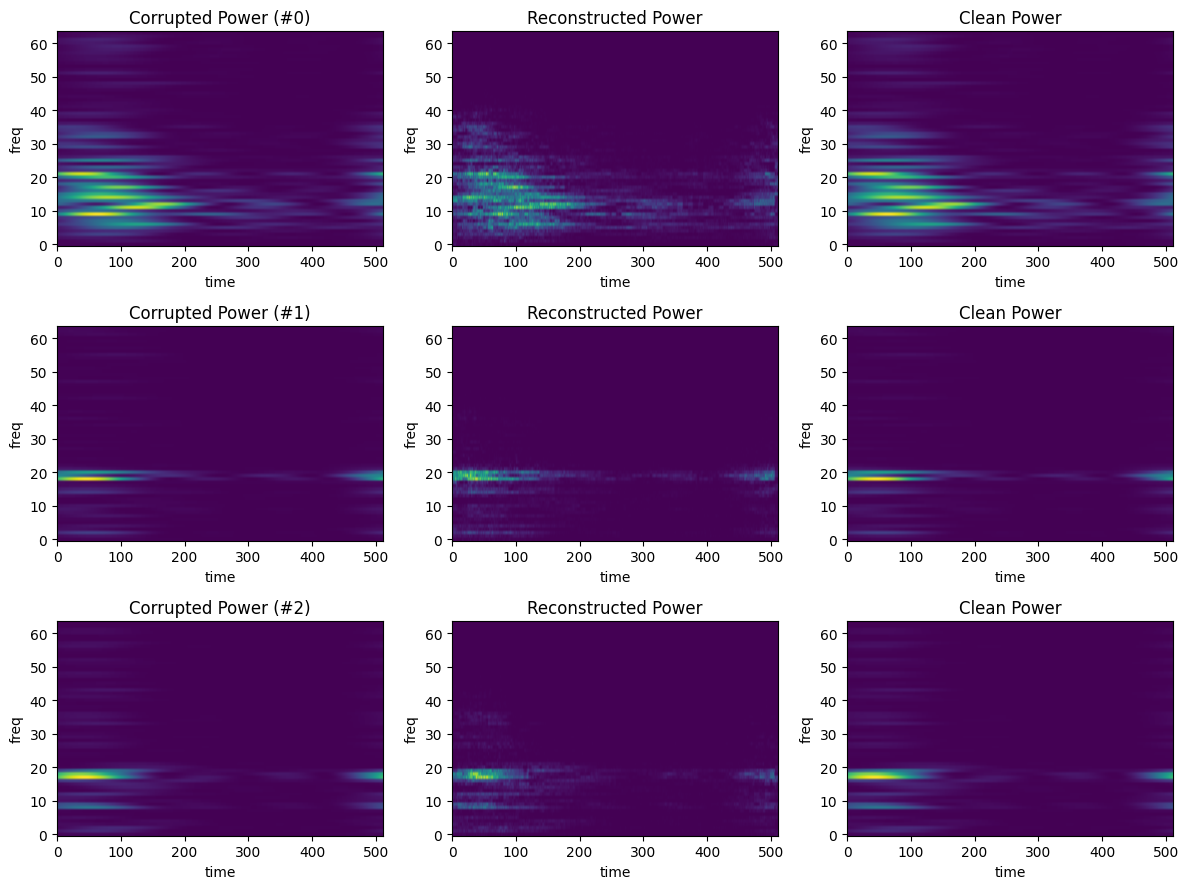

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def to_numpy(x):
    return x.detach().cpu().numpy()

def imshow(ax, img, title="", vmin=None, vmax=None):
    ax.imshow(img, aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
    ax.set_title(title); ax.set_xlabel("time"); ax.set_ylabel("freq")

def phys_mag(x, width=4):
    """
    x: [2, F, T] real+imag tensor/array
    width: wavelet bandwidth parameter
    returns: [F, T] power magnitude
    """
    if isinstance(x, torch.Tensor):
        re, im = x[0], x[1]
        c_abs2 = re**2 + im**2
        return c_abs2 / (2 * np.pi * width)
    else:  # numpy
        re, im = x[0], x[1]
        c_abs2 = re**2 + im**2
        return c_abs2 / (2 * np.pi * width)

@torch.no_grad()
def visualize_latent_feature_maps(model, loader, device, n_samples=3):
    Xc, Yc, c = next(iter(loader))
    Yc = Yc.to(device)[:n_samples]
    z = model.encode(Yc)  # [n,2,32,64]
    z_np = z.cpu().numpy()

    fig, axes = plt.subplots(n_samples, 2, figsize=(8, 3*n_samples))
    if n_samples == 1: axes = axes[None, :]
    for i in range(n_samples):
        imshow(axes[i,0], z_np[i,0], title=f"Latent Re (#{i})")
        imshow(axes[i,1], z_np[i,1], title=f"Latent Im (#{i})")
    plt.tight_layout(); plt.show()

@torch.no_grad()
def visualize_reconstructions(model, loader, device, n_rows=3):
    """
    For a few samples: show magnitude of corrupted, reconstructed, and clean.
    """
    model.eval()
    Xc, Yc, c = next(iter(loader))
    Xc = Xc.to(device)[:n_rows]
    Yc = Yc.to(device)[:n_rows]

    Xhat, z = model(Yc)  # denoising

    Xc_np   = to_numpy(Xc)
    Yc_np   = to_numpy(Yc)
    Xhat_np = to_numpy(Xhat)

    def mag(x):  # x: [2,F,T] -> [F,T] magnitude
        return np.sqrt(x[0]**2 + x[1]**2)

    fig, axes = plt.subplots(n_rows, 3, figsize=(12, 3*n_rows))
    if n_rows == 1: axes = axes[None, :]
    for i in range(n_rows):
        imshow(axes[i,0], mag(Yc_np[i]),   title=f"Corrupted |Y| (#{i})")
        imshow(axes[i,1], mag(Xhat_np[i]), title="Reconstructed |X̂|")
        imshow(axes[i,2], mag(Xc_np[i]),   title="Clean |X|")
    plt.tight_layout(); plt.show()

@torch.no_grad()
def visualize_reconstructions_phys(model, loader, device, n_rows=3, width=4):
    """
    Show corrupted, reconstructed, and clean signals using
    the physical magnitude definition |c|^2 / (2*pi*width).
    """
    model.eval()
    Xc, Yc, c = next(iter(loader))
    Xc = Xc.to(device)[:n_rows]
    Yc = Yc.to(device)[:n_rows]

    Xhat, z = model(Yc)  # denoising forward

    Xc_np   = Xc.cpu().numpy()
    Yc_np   = Yc.cpu().numpy()
    Xhat_np = Xhat.cpu().numpy()

    fig, axes = plt.subplots(n_rows, 3, figsize=(12, 3*n_rows))
    if n_rows == 1: axes = axes[None, :]
    for i in range(n_rows):
        magY = phys_mag(Yc_np[i], width)
        magH = phys_mag(Xhat_np[i], width)
        magX = phys_mag(Xc_np[i], width)

        imshow(axes[i,0], magY, title=f"Corrupted Power (#{i})")
        imshow(axes[i,1], magH, title="Reconstructed Power")
        imshow(axes[i,2], magX, title="Clean Power")

    plt.tight_layout(); plt.show()

device = "cuda" if torch.cuda.is_available() else "cpu"
model = ComplexCAE_LatentMap(base=32).to(device)
model= torch.load("cae_denoise_best.pt", weights_only=False, map_location=device)  # if you saved state_dict

# Latent feature maps (few samples from val set)
visualize_latent_feature_maps(model, val_loader, device, n_samples=3)

# Reconstructions triptych (corrupted vs reconstructed vs clean)
visualize_reconstructions_phys(model, val_loader, device, n_rows=3)